# BigEarthNetv2 data preparation
The BigEarthNetv2 dataset contains 549488 Sentinel-2 image patches with the corresponding mask that can be used to train a model for satellite image classification and segmentation. For each scene dhe dataset contains 12 of the 13 bands available, that is, all but B10. More information about the dataset is available at the [BigEarthNet](https://bigearth.net/) website.

* B01 (resolution = 60m/px, central wavelength = 443nm, bandwidth = 20nm, use: aerosol detection)
* B02 (blue, resolution = 10m/px, central wavelength = 490nm, bandwidth = 65nm, use: Band 2 is useful for soil and vegetation discrimination, forest type mapping and identifying man-made features. It is scattered by the atmosphere, it illuminates material in shadows better than longer wavelengths, and it penetrates clear water better than other colors. It is absorbed by chlorophyll, which results in darker plants.)
* B03 (green, resolution = 10m/px, central wavelength = 560nm, bandwidth = 35nm, use: it gives excellent contrast between clear and turbid (muddy) water, and penetrates clear water fairly well. It helps in highlighting oil on water surfaces, and vegetation. It reflects green light stronger than any other visible color. Man-made features are still visible)
* B04 (red, resolution = 10m/px, central wavelength = 665nm, bandwidth = 30nm, use: it is strongly reflected by dead foliage and is useful for identifying vegetation types, soils and urban (city and town) areas. It has limited water penetration and doesn’t reflect well from live foliage with chlorophyll.)
* B05 (red edge, resolution = 20m/px, central wavelength = 705nm, bandwidth = 15nm, use: vegetation classification)
* B06 (resolution = 20m/px, central wavelength = 740nm, bandwidth = 15nm, use: vegetation classification)
* B07 (resolution = 20m/px, central wavelength = 783nm, bandwidth = 20nm, use: vegetation classification)
* B08 (NIR, resolution = 10m/px, central wavelength = 842nm, bandwidth = 115nm, use: The near infrared band is good for mapping shorelines and biomass content, as well as at detecting and analyzing vegetation)
* B8A (resolution = 20m/px, central wavelength = 865nm, bandwidth = 20nm, use: For classifying vegetation)
* B09 (resolution = 60m/px, central wavelength = 945nm, bandwidth = 20nm, use: it is good for detecting water vapour)
* B10 (resolution = 60m/px, central wavelength = 1375nm, bandwidth = 30nm, use: For cirrus cloud detection)
* B11 (SWIR 1, resolution = 20m/px, central wavelength = 1610nm, bandwidth = 90nm, use: It is useful for measuring the moisture content of soil and vegetation, and it provides good contrast between different types of vegetation. It helps differentiate between snow and clouds. On the other hand, it has limited cloud penetration)
* B12 (SWIR 2, resolution = 20m/px, central wavelength = 2190nm, bandwidth = 180nm, use: It is useful for measuring the moisture content of soil and vegetation, and it provides good contrast between different types of vegetation. It helps differentiate between snow and clouds. On the other hand, it has limited cloud penetration)

We will use only the three RGB bands: B02 (blue), B03 (green), and B04 (red). The masks have been created using 19 classes of the CORINE Land Cover (CLC) nomenclature. The data preparation phase consists of 

1. Convert the TIFF bands of a scene into PNG files
2. Stack together in one PNG file the three bands for each scene
3. Create three datasets for training, validation and test


## Structure of the dataset
The BigEarthNetv2 dataset is organized into two root folders, one for the images and one for the masks, like in the following example with only two image patches of one scene. 
* BigEarthNet-S2
    * images
        * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP
            * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B02.tif
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B03.tif
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B04.tif
            * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B02.tif
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B03.tif
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B04.tif
    * masks
        * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP
            * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_reference_map.tif
            * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_reference_map.tif

The images leaf folders contain 12 TIFF images, one for each Sentinel-2 bands. The masks leaf folder contain only one TIFF file. The file name is built using the convention  
satellite_sensor_date_scene-part1_scene-part2_scene-part3_code-number1_code-number2

In [6]:
import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import matplotlib
import matplotlib.pyplot as plt
import rasterio
import warnings
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print("Matplotlib version: %s"%matplotlib.__version__)
print("rasterio version: %s"%rasterio.__version__)

NumPy version: 1.26.4
Matplotlib version: 3.8.4
rasterio version: 1.4.3


In [7]:
IMAGES_DATA_DIR = pathlib.Path('data/BigEarthNet-S2/images')
MASKS_DATA_DIR = pathlib.Path('data/BigEarthNet-S2/masks')

In [38]:
def list_data_files(root_path):
    patch_paths = []
    scene_paths = [pathlib.Path(x) for x in root_path.iterdir() if x.is_dir()]
    for scene_path in scene_paths:
        for patch_path in scene_path.iterdir():
            for file in patch_path.iterdir():
                band_type = file.name[-7:]
                #print(band_type)
                if (band_type == 'B02.tif' or band_type == 'B03.tif' or band_type == 'B04.tif' or band_type == 'map.tif'):
                    patch_paths.append(file)
    return patch_paths

In [39]:
image_patches = list_data_files(IMAGES_DATA_DIR)
len(image_patches)

6

In [40]:
for image in image_patches:
    print(image.name)

S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B02.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B03.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B04.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B02.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B03.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B04.tif


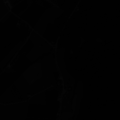

In [50]:
PIL.Image.open(image_patches[0])

In [41]:
mask_patches = list_data_files(MASKS_DATA_DIR)
len(mask_patches)

2

In [42]:
for mask in mask_patches:
    print(mask.name)

S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_reference_map.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_reference_map.tif


In [43]:
img_path = image_patches[0]
img_path.name

'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B02.tif'

In [44]:
dataset = rasterio.open(img_path)
dataset.width, dataset.height

(120, 120)

In [45]:
dataset.bounds

BoundingBox(left=331200.0, bottom=5330400.0, right=332400.0, top=5331600.0)

In [46]:
print(dataset.crs)

EPSG:32633


In [47]:
band = dataset.read(1)